In [1]:
# Boolean aliases ----
T = True
F = False
# Standard libs ----
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.cluster.hierarchy import cut_tree
from sklearn.manifold import MDS
# Personal libs ---- 
from networks.toy import TOY
from networks.MAC.mac57 import MAC57
from modules.hierarmerge import Hierarchy
from plotting_modules.plotting_H import Plot_H
from plotting_modules.plotting_N import Plot_N
from modules.hierarentropy import Hierarchical_Entropy
from modules.flatmap import FLATMAP
from modules.colregion import colregion
from various.data_transformations import maps
from modules.discovery import discovery_channel
from various.network_tools import *

def cartesian_to_spherical(xyz):
    ptsnew = np.zeros(xyz.shape)
    xy = xyz[:,0]**2 + xyz[:,1]**2
    ptsnew[:,0] = np.sqrt(xy + xyz[:,2]**2)
    ptsnew[:,2] = np.arctan2(np.sqrt(xy), xyz[:,2])
    ptsnew[:,1] = np.arctan2(xyz[:,1], xyz[:,0])
    return ptsnew

def find_index_span(z, boundaries, bins):
    for i in np.arange(bins):
      if (boundaries[i] <= z) and (boundaries[i+1] > z):
          return i
    return -1

Rz = lambda phi: np.array(
[
  [np.cos(phi), np.sin(phi), 0],
  [-np.sin(phi), np.cos(phi), 0],
  [0, 0, 1]
]
)

Ry = lambda phi: np.array(
[
  [np.cos(phi), 0, -np.sin(phi)],
  [0,1, 0],
  [np.sin(phi), 0, np.cos(phi)]
]
)

# Declare global variables ----
linkage = "single"
nlog10 = F
lookup = F
prob = F
cut = F
structure = "FLNe"
mode = "ZERO"
distance = "tracto16"
nature = "original"
imputation_method = ""
topology = "MIX"
mapping = "trivial"
index  = "Hellinger2"
discovery = "discovery_7"
bias = 0.0
opt_score = ["_S"]
save_data = T
version = "57d106"
__nodes__ = 57
__inj__ = 57

/Users/jmarti53/Documents/Projects/LINKPROJECT/.env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
NET = MAC57(
  linkage, mode,
  nlog10 = nlog10,
  structure = structure,
  lookup = lookup,
  version = version,
  nature = nature,
  model = imputation_method,
  distance = distance,
  inj = __inj__,
  topology = topology,
  index = index,
  mapping = mapping,
  cut = cut,
  b = bias
)

NET_H = read_class(
  NET.pickle_path,
  "hanalysis"
)

FLNe_ENSEMBLE = []
OMG_ENSEMBLE = []
bins = 12

D = NET.D
NEURONS = NET.C

properties = {
  "version" : "3Dfit",
  "nlog10" : nlog10,
  "lookup" : lookup,
  "prob" : prob,
  "cut" : cut,
  "topology" : topology,
  "mapping" : mapping,
  "index" : index,
  "mode" : mode,
}

trials = 0
NUMBER_TRIALS = 1000
while trials < NUMBER_TRIALS:

  embedding = MDS(n_components=3, dissimilarity="precomputed")
  Xt = embedding.fit_transform(D)

  Xt = (Xt - np.mean(Xt, axis=0)) / np.std(Xt, axis=0)

  # Coordinate transformation ----

  iv1 = np.where(NET.struct_labels == "v1c")[0][0]
  V1 = Xt[iv1, :]
  i8L = np.where(NET.struct_labels == "8l")[0][0]
  a8L = Xt[i8L, :]

  u = (a8L - V1)
  from scipy.linalg import norm
  u /= norm(u)
  u = cartesian_to_spherical(u.reshape(1, -1)).ravel()

  Tr = Ry(u[2]) @ Rz(u[1])

  for i in np.arange(NET.rows):
    Xt[i, :] = (Tr @ Xt[i, :].reshape(-1, 1)).reshape(1, -1)

  # Calibrate perpendicular axis

  iv1 = np.where(NET.struct_labels == "10")[0][0]
  V1 = Xt[iv1, :]
  i8L = np.where(NET.struct_labels == "aip")[0][0]
  a8L = Xt[i8L, :]

  u = (a8L - V1)
  u /= norm(u)
  u = cartesian_to_spherical(u.reshape(1, -1)).ravel()

  Tr = Rz(u[1])
  for i in np.arange(NET.rows):
    Xt[i, :] = (Tr @ Xt[i, :].reshape(-1, 1)).reshape(1, -1)

  rmin, rmax = np.Inf, -np.Inf
  theta_min, theta_max =  np.Inf, -np.Inf
  phi_min, phi_max =  np.Inf, -np.Inf

  for i in np.arange(NET.rows):
    for j in np.arange(NET.rows):
      if i == j: continue
      vij = Xt[j, :] - Xt[i, :]
      vij = cartesian_to_spherical(vij.reshape(1, -1)).ravel()
      if vij[0] < rmin: rmin = vij[0]
      if vij[0] > rmax: rmax = vij[0]
      if vij[2] < theta_min: theta_min = vij[2]
      if vij[2] > theta_max: theta_max = vij[2]
      if vij[1] < phi_min: phi_min = vij[1]
      if vij[1] > phi_max: phi_max = vij[1]



  R_span = np.linspace(rmin, rmax, bins+1)
  R_span[0] -=1
  R_span[-1] += 1

  Theta_span = np.linspace(theta_min, theta_max, bins+1)
  Theta_span[0] -= 1
  Theta_span[-1] += 1

  Phi_span = np.linspace(phi_min, phi_max, bins+1)
  Phi_span[0] -= 1
  Phi_span[-1] += 1

  P = np.zeros((bins, bins, bins))

  connections_dict = {}

  for i in np.arange(NET.rows):
    for j in np.arange(NET.rows):
      if i == j: continue
      vij = Xt[j, :] - Xt[i, :]
      vij = cartesian_to_spherical(vij.reshape(1, -1)).ravel()
      ir = find_index_span(vij[0], R_span, bins)
      if ir == -1: raise ValueError("Index can't be negative")
      itheta = find_index_span(vij[2], Theta_span, bins)
      if itheta == -1: raise ValueError("Index can't be negative")
      iphi = find_index_span(vij[1], Phi_span, bins)
      if iphi == -1: raise ValueError("Index can't be negative")
      if (ir, iphi, itheta) not in connections_dict:
        connections_dict[(ir, iphi, itheta)] = [(i, j)]
      else: connections_dict[(ir, iphi, itheta)].append((i, j))
      if j < NET.nodes:
        P[ir, iphi, itheta] += NEURONS[i, j]

  P /= np.sum(P)

  R_span[0] +=1
  R_span[-1] -= 1

  Theta_span[0] += 1
  Theta_span[-1] -= 1

  Phi_span[0] += 1
  Phi_span[-1] -= 1

  # 3 ----

  L = bins * bins * bins
  E = np.zeros((L, 4))

  e = 0
  for i in np.arange(bins):
    for j in np.arange(bins):
      for k in np.arange(bins):
        E[e, 0] = i
        E[e, 1] = j
        E[e, 2] = k
        E[e, 3] = P[i,j,k]
        e += 1

  Nmodel = np.zeros((NET.rows, NET.rows))
  rng = np.random.default_rng()

  M = 0
  nonzero = np.sum(NET.C > 0)

  while M < nonzero:
    experiment = np.random.choice(E.shape[0], size=1000, p=E[:, -1].ravel())
    for exp in experiment:
        ternary = (int(E[exp, 0]), int(E[exp, 1]), int(E[exp, 2]))
        if ternary in connections_dict:
          len_ternary = len(connections_dict[ternary])
          t = np.random.randint(len_ternary)
          i, j = connections_dict[ternary][t]
          Nmodel[i, j] +=1
          M = np.sum(Nmodel[:,:NET.nodes] > 0)
        if M >= nonzero: break

  Pmodel = Nmodel.copy()
  Pmodel /= np.sum(Nmodel, axis=0)
  FLNe_ENSEMBLE.append(Pmodel)

  # 4 ----

  toy = TOY(Pmodel[:, :NET.nodes], linkage, **properties)
  toy.set_labels(NET.struct_labels)
  # toy.create_plot_directory()
  H = Hierarchy(
    toy, Pmodel[:, :NET.nodes], Pmodel[:, :NET.nodes], NET.D,
    __nodes__, linkage, mode, lookup=lookup,
    index=index
  )
  H.BH_features_cpp_no_mu()
  H.la_abre_a_merde_cpp(H.BH[0])
  H.get_h21merge()
  L = colregion(NET, labels_name=f"labels{__inj__}")
  H.set_colregion(L)
  H.delete_dist_matrix()

  for SCORE in opt_score:
    # Get best K and R ----
    K, R, TH = get_best_kr_equivalence(SCORE, H)
    for k, r, th in zip(K, R, TH):
      print(f"Find node partition using {SCORE}")
      print("Best K: {}\nBest R: {}\t Score: {}".format(k, r, SCORE))
      H.set_kr(k, r, score=SCORE)
      rlabels = get_labels_from_Z(H.Z, r)
      rlabels = skim_partition(rlabels)
      
      # Overlap ----
      for direction in ["both"]: # "source", "target", 
        print("***", direction)
        toy.overlap, toy.data_nocs, noc_sizes, rlabels2  = discovery_channel[discovery](H, k, rlabels, direction=direction, index=index)
        print(">>> Areas with predicted overlapping communities:\n",  toy.data_nocs, "\n")
        cover = omega_index_format(rlabels2,  toy.data_nocs, toy.struct_labels[:toy.nodes])
        OMGi = omega_index(cover, NET_H.cover[direction]["_S"])
        OMG_ENSEMBLE.append(OMGi)
        
  trials += 1

In [3]:
sns.set_style("ticks")

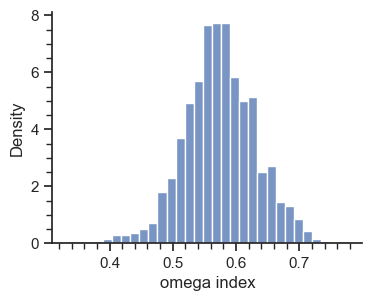

In [4]:
# Omega index trials histogram ----

data = {"omega index" : OMG_ENSEMBLE}

fig = plt.gcf()
ax = plt.gca()
ax.minorticks_on()

sns.histplot(data, x="omega index",stat="density", ax=ax)
sns.despine(ax=ax, top=T, right=T)

fig.set_figwidth(4)
fig.set_figheight(3)

In [5]:
FLNe_ENSEMBLE = np.array(FLNe_ENSEMBLE)

In [ ]:
OMG_ENSEMBLE_PROGRESSION = []
nonzero = np.sum(NET.C > 0)

for i in np.arange(NUMBER_TRIALS):
    A = np.mean(FLNe_ENSEMBLE[:(i+1)], axis=0)
    dA = adj2df(A).sort_values("weight")

    nonzero_M = np.sum(A[:, :NET.nodes] > 0)
    e = 0
    while nonzero_M > nonzero:
        A[dA["source"].iloc[e], dA["target"].iloc[e]] = 0
        e += 1
        nonzero_M = np.sum(A[:, :NET.nodes] > 0)

    toy = TOY(A[:, :NET.nodes], linkage, **properties)
    toy.set_labels(NET.struct_labels)
    # toy.create_plot_directory()
    H = Hierarchy(
        toy, A[:, :NET.nodes], A[:, :NET.nodes], NET.D,
        __nodes__, linkage, mode, lookup=lookup,
        index=index
    )
    H.BH_features_cpp_no_mu()
    H.la_abre_a_merde_cpp(H.BH[0])
    H.get_h21merge()
    L = colregion(NET, labels_name=f"labels{__inj__}")
    H.set_colregion(L)
    H.delete_dist_matrix()

    for SCORE in opt_score:
        # Get best K and R ----
        K, R, TH = get_best_kr_equivalence(SCORE, H)
        for k, r, th in zip(K, R, TH):
            print(f"Find node partition using {SCORE}")
            print("Best K: {}\nBest R: {}\t Score: {}".format(k, r, SCORE))
            H.set_kr(k, r, score=SCORE)
            rlabels = get_labels_from_Z(H.Z, r)
            rlabels = skim_partition(rlabels)
        
            # Overlap ----
            for direction in ["both"]: # "source", "target", 
                print("***", direction)
                toy.overlap, toy.data_nocs, noc_sizes, rlabels2  = discovery_channel[discovery](H, k, rlabels, direction=direction, index=index)
                print(">>> Areas with predicted overlapping communities:\n",  toy.data_nocs, "\n")
                cover = omega_index_format(rlabels2,  toy.data_nocs, toy.struct_labels[:toy.nodes])
                OMGi = omega_index(cover, NET_H.cover[direction]["_S"])
                OMG_ENSEMBLE_PROGRESSION.append(OMGi)
    

0.6045961011087179


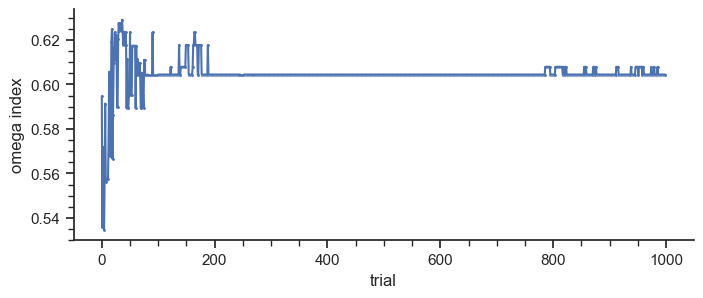

In [12]:
data = {
    "trial" : np.arange(NUMBER_TRIALS),
    "omega index" : OMG_ENSEMBLE_PROGRESSION
}

fig = plt.gcf()
ax = plt.gca()
ax.minorticks_on()

sns.scatterplot(
  data=data,
  x="trial",
  y="omega index",
  s=5,
  ax=ax
)
sns.lineplot(
  data=data,
  x="trial",
  y="omega index",
  ax=ax
)

# ax.hlines(np.mean(OMG_ENSEMBLE_PROGRESSION), xmin=0, xmax=NUMBER_TRIALS, colors="r", linestyles="--")
print(np.mean(OMG_ENSEMBLE_PROGRESSION))

sns.despine(ax=ax, top=T, right=T)

fig.set_figwidth(8)
fig.set_figheight(3)

(0.6059744499351559, 1.8575913850244368e-263)

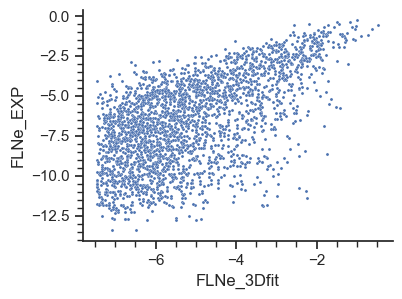

In [8]:
A = np.mean(FLNe_ENSEMBLE, axis=0)
dA = adj2df(A).sort_values("weight")

nonzero_M = np.sum(A[:, :NET.nodes] > 0)
e = 0
while nonzero_M > nonzero:
    A[dA["source"].iloc[e], dA["target"].iloc[e]] = 0
    e += 1
    nonzero_M = np.sum(A[:, :NET.nodes] > 0)

Aexp = NET.A.copy()
Aexp[Aexp == 0] = np.nan
A[A == 0] = np.nan

Aexp = np.log(Aexp)
A = np.log(A)
A = A[:, :NET.nodes]

data = {
  "FLNe_EXP" : Aexp.ravel(),
  "FLNe_3Dfit" : A.ravel()
}

fig = plt.gcf()
ax = plt.gca()
ax.minorticks_on()

sns.scatterplot(
  data=data,
  x="FLNe_3Dfit",
  y="FLNe_EXP",
  s=5,
  ax=ax
)

fig.set_figwidth(4)
fig.set_figheight(3)

sns.despine(ax=ax, top=T, right=T)

from scipy.stats import pearsonr
Aexp = Aexp.ravel()
A = A.ravel()

skip = (~np.isnan(Aexp)) & (~np.isnan(A))
pearsonr(Aexp[skip], A[skip])

(0.6800240440409799, 0.0)

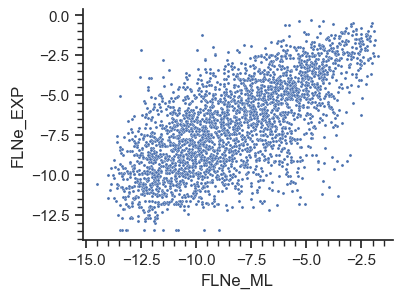

In [9]:
A_ML = pd.read_csv("FLN_ML_57d106_GB4.csv", header=0).to_numpy()
A_ML[A_ML == 0] = np.nan
A_ML = A_ML[:, :NET.nodes]
A_ML = np.log(A_ML)

data = {
  "FLNe_EXP" : Aexp.ravel(),
  "FLNe_ML" : A_ML.ravel()
}

fig = plt.gcf()
ax = plt.gca()
ax.minorticks_on()

sns.scatterplot(
  data=data,
  x="FLNe_ML",
  y="FLNe_EXP",
  s=5,
  ax=ax
)

fig.set_figwidth(4)
fig.set_figheight(3)

sns.despine(ax=ax, top=T, right=T)

from scipy.stats import pearsonr
Aexp = Aexp.ravel()
A_ML = A_ML.ravel()

skip = (~np.isnan(Aexp)) & (~np.isnan(A_ML))
pearsonr(Aexp[skip], A_ML[skip])

In [10]:
A_ML = pd.read_csv("FLN_ML_57d106_GB4.csv", header=0).to_numpy()

toy = TOY(A_ML[:, :NET.nodes], linkage, **properties)
toy.set_labels(NET.struct_labels)
# toy.create_plot_directory()
H = Hierarchy(
    toy, A_ML[:, :NET.nodes], A_ML[:, :NET.nodes], NET.D,
    __nodes__, linkage, mode, lookup=lookup,
    index=index
)
H.BH_features_cpp_no_mu()
H.la_abre_a_merde_cpp(H.BH[0])
H.get_h21merge()
L = colregion(NET, labels_name=f"labels{__inj__}")
H.set_colregion(L)
H.delete_dist_matrix()

for SCORE in opt_score:
    # Get best K and R ----
    K, R, TH = get_best_kr_equivalence(SCORE, H)
    for k, r, th in zip(K, R, TH):
        print(f"Find node partition using {SCORE}")
        print("Best K: {}\nBest R: {}\t Score: {}".format(k, r, SCORE))
        H.set_kr(k, r, score=SCORE)
        rlabels = get_labels_from_Z(H.Z, r)
        rlabels = skim_partition(rlabels)
    
        # Overlap ----
        for direction in ["both"]: # "source", "target", 
            print("***", direction)
            toy.overlap, toy.data_nocs, noc_sizes, rlabels2  = discovery_channel[discovery](H, k, rlabels, direction=direction, index=index)
            print(">>> Areas with predicted overlapping communities:\n",  toy.data_nocs, "\n")
            cover = omega_index_format(rlabels2,  toy.data_nocs, toy.struct_labels[:toy.nodes])
            omega_index(cover, NET_H.cover[direction]["_S"])

Compute link hierarchical agglomeration ----
source lambda:
 0.12582127006076388
target lambda:
 0.09664972775735194
source characteristic length: 17.588890141755865
target characteristic length: 20.361786525351356
Mu-free


/Users/jmarti53/Documents/Projects/LINKPROJECT/Dlink/modules/hierarmerge.py:710: RuntimeWarning: divide by zero encountered in log
  src_inset[i, j] = -2 * np.log(ct.Hellinger2(self.A[i, :], self.A[j, :], i, j))


Compute node hierarchy ----
Commencer: la abre a merde
25%
50%
75%
Voila, bon ami
Find node partition using _S
Best K: 94
Best R: 19	 Score: _S
*** both
>>> Areas with predicted overlapping communities:
 {'v1fpuf': [0, 1], '7b': [3, 5], '5': [3, 5], 'th/tf': [0, 1, 2], 'f3': [3, 5, 6], 'opro': [6, 7], '12': [5, 6]} 

Omega: 0.6451
